In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import math
import random
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import QuantileTransformer
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Read dataset

df = pd.read_csv('./attacks_data/balanced_dataset.csv')

In [3]:
df.Label.value_counts()

Benign                      762384
SQL Injection               686012
Brute Force -XSS            686012
Brute Force -Web            686012
DDOS attack-LOIC-UDP        686012
DoS attacks-Slowloris       686012
DoS attacks-GoldenEye       686012
Infilteration               686012
DoS attacks-SlowHTTPTest    686012
SSH-Bruteforce              686012
FTP-BruteForce              686012
DoS attacks-Hulk            686012
Bot                         686012
DDoS attacks-LOIC-HTTP      686012
DDOS attack-HOIC            686012
Name: Label, dtype: int64

In [4]:
# dff = df.sample(n=2500000)
# dff = df.copy()

dff = df.sample(n=10)

In [6]:
dff.to_csv('./attacks_data/sample_dataset.csv', index=False)

In [6]:
dff.Label.value_counts()

Benign                      183921
DoS attacks-SlowHTTPTest    165890
DDoS attacks-LOIC-HTTP      165857
Bot                         165754
SSH-Bruteforce              165671
Brute Force -XSS            165611
DoS attacks-GoldenEye       165502
Brute Force -Web            165497
SQL Injection               165477
DDOS attack-LOIC-UDP        165302
FTP-BruteForce              165269
DoS attacks-Hulk            165232
DDOS attack-HOIC            165127
DoS attacks-Slowloris       164958
Infilteration               164932
Name: Label, dtype: int64

In [7]:
df.columns

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std',
       'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean',
       'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot',
       'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min',
       'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags',
       'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s',
       'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std',
       'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt',
       'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count',
       'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg',
       'Bwd Se

In [8]:
dff.head()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
8068828,8080,6,500,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.000000,4000.000000,5.000000e+02,0.000000,500.0,500.0,500.0,5.000000e+02,0.000000,500.0,500.0,0.0,0.000000,0.000000,0.0,0.0,0,0,0,0,40,0,4000.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.00000,0.000000,0.00,0,0,0,0,0,0,2,0,0,0,2052,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
5658427,22,6,389628,22,20,1912.0,2665.0,640.0,0.0,86.909091,137.688022,976.0,0.0,133.25,268.771254,107.795128,9.503122e+03,23530.372438,135298.0,2.0,389585.0,1.855167e+04,33171.454414,135298.0,151.0,389625.0,20506.578947,42802.073904,174292.0,7.0,0,0,0,0,712,648,56.464114,51.331013,0.0,976.0,106.44186,207.291869,42969.919158,0,0,0,1,0,0,0,0,0.0,108.97619,86.909091,133.25,0,0,0,0,0,0,22,1912,20,2665,26883,230,16,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SSH-Bruteforce
7479491,80,6,11314,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.000000,176.772141,1.131400e+04,0.000000,11314.0,11314.0,11314.0,1.131400e+04,0.000000,11314.0,11314.0,0.0,0.000000,0.000000,0.0,0.0,0,0,0,0,64,0,176.772141,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.00000,0.000000,0.00,0,0,0,0,0,0,2,0,0,0,225,-1,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS attacks-Hulk
8521871,80,6,36704065,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.054490,3.670000e+07,0.000000,36700000.0,36700000.0,36700000.0,3.670000e+07,0.000000,36700000.0,36700000.0,0.0,0.000000,0.000000,0.0,0.0,0,0,0,0,40,0,0.054490,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.00000,0.000000,0.00,0,0,0,0,0,0,2,0,0,0,2049,-1,0,20,0.0,0.0,0.0,0.0,36700000.0,0.0,36700000.0,36700000.0,DDoS attacks-LOIC-HTTP
17682,80,6,23,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.000000,86956.521739,2.300000e+01,0.000000,23.0,23.0,23.0,2.300000e+01,0.000000,23.0,23.0,0.0,0.000000,0.000000,0.0,0.0,0,0,0,0,40,0,86956.521739,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.00000,0.000000,0.00,0,0,0,0,0,0,2,0,0,0,2053,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SQL Injection


In [9]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
len(dff)

2500000

In [11]:
# cols = dff.columns.difference(['Label'])
# # convert the relevant columns
# dff[cols] = dff[cols].astype(float)

Y = dff['Label'].to_frame()
X = dff.drop('Label', axis=1)
X = X.astype(float)

# mapping = {'Trojan': 1, 'Benign': 0}
mapping = {value: index for index, value in enumerate(dff.columns)}
# Apply the mapping to the "target" column
Y['Label'] = Y['Label'].map(mapping)

In [ ]:
from pymrmre import mrmr
# from mrmr import mrmr_classif
solutions = mrmr.mrmr_ensemble(features=X, targets=Y, solution_length=15, solution_count=10)

In [15]:
solutions[0]

[['Label',
  'Label',
  'Label',
  'Label',
  'Label',
  'Label',
  'Label',
  'Label',
  'Label',
  'Label',
  'Label',
  'Label',
  'Label',
  'Label',
  'Label']]

In [9]:
reduced_df = dff.iloc[:, 0:15]
reduced_df = pd.concat([reduced_df, dff['Label']], axis=1)

In [10]:
reduced_df= reduced_df.reset_index()

In [11]:
# Transform all features into the scale of [0,1]
# reduced_df.reset_index()
numeric_features = reduced_df.dtypes[reduced_df.dtypes != 'object'].index
scaler = QuantileTransformer() 
reduced_df[numeric_features] = scaler.fit_transform(reduced_df[numeric_features])

In [12]:
# 
reduced_df[numeric_features] = reduced_df[numeric_features].apply(
    lambda x: (x*255))

In [13]:
reduced_df.describe()

,index,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std
count,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06
mean,1.269751e+02,1.269097e+02,1.292877e+02,1.279095e+02,1.214489e+02,1.067623e+02,9.325825e+01,7.247530e+01,9.328141e+01,3.345029e+01,9.357227e+01,7.372860e+01,7.211550e+01,9.740213e+00,7.278489e+01,6.617459e+01
std,7.386003e+01,6.572816e+01,4.706298e+01,7.413647e+01,8.140258e+01,9.301786e+01,9.889889e+01,1.010198e+02,9.894174e+01,8.269133e+01,9.925851e+01,1.022053e+02,1.005553e+02,4.836843e+01,1.014184e+02,1.003267e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.248884e+01,1.361787e+02,1.126952e+02,6.406907e+01,9.610360e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.271001e+02,1.361787e+02,1.126952e+02,1.280831e+02,9.610360e+01,1.315841e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.909588e+02,1.361787e+02,1.126952e+02,1.930617e+02,1.895270e+02,2.033108e+02,1.905480e+02,1.899099e+02,1.918243e+02,0.000000e+00,1.906757e+02,1.930192e+02,1.883784e+02,0.000000e+00,1.905480e+02,1.916967e+02
max,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02


In [14]:
reduced_df.Label.unique()

array(['DDOS attack-HOIC', 'Brute Force -Web', 'DoS attacks-GoldenEye',
       'Brute Force -XSS', 'Bot', 'FTP-BruteForce',
       'DDOS attack-LOIC-UDP', 'DoS attacks-SlowHTTPTest', 'Benign',
       'Infilteration', 'DDoS attacks-LOIC-HTTP', 'DoS attacks-Slowloris',
       'DoS attacks-Hulk', 'SQL Injection', 'SSH-Bruteforce'],
      dtype=object)

In [15]:
df0 = reduced_df[reduced_df['Label']=='DDOS attack-HOIC'].drop(['Label'],axis=1)
df1 = reduced_df[reduced_df['Label']=='FTP-BruteForce'].drop(['Label'],axis=1) 
df2 = reduced_df[reduced_df['Label']=='Bot'].drop(['Label'],axis=1) 
df3 = reduced_df[reduced_df['Label']=='SSH-Bruteforce'].drop(['Label'],axis=1)
df4 = reduced_df[reduced_df['Label']=='Infilteration'].drop(['Label'],axis=1) 
df5 = reduced_df[reduced_df['Label']=='DoS attacks-GoldenEye'].drop(['Label'],axis=1) 
df6 = reduced_df[reduced_df['Label']=='DDoS attacks-LOIC-HTTP'].drop(['Label'],axis=1)
df7 = reduced_df[reduced_df['Label']=='Brute Force -Web'].drop(['Label'],axis=1) 
df8 = reduced_df[reduced_df['Label']=='Brute Force -XSS'].drop(['Label'],axis=1) 
df9 = reduced_df[reduced_df['Label']=='SQL Injection'].drop(['Label'],axis=1)
df10 = reduced_df[reduced_df['Label']=='DoS attacks-SlowHTTPTest'].drop(['Label'],axis=1) 
df11 = reduced_df[reduced_df['Label']=='DoS attacks-Hulk'].drop(['Label'],axis=1)
df12= reduced_df[reduced_df['Label']=='DoS attacks-Slowloris'].drop(['Label'],axis=1) 
df13 = reduced_df[reduced_df['Label']=='DDOS attack-LOIC-UDP'].drop(['Label'],axis=1) 
df14 = reduced_df[reduced_df['Label']=='Benign'].drop(['Label'],axis=1) 

In [16]:
# df0 = reduced_df[reduced_df['Label']=='DDOS attack-HOIC'].drop(['Label'],axis=1)
# df1 = reduced_df[reduced_df['Label']=='DoS attacks-Slowloris'].drop(['Label'],axis=1)
# df2 = reduced_df[reduced_df['Label']=='DoS attacks-SlowHTTPTest'].drop(['Label'],axis=1)
# df3 = reduced_df[reduced_df['Label']=='SQL Injection'].drop(['Label'],axis=1)
# df4 = reduced_df[reduced_df['Label']=='Brute Force -XSS'].drop(['Label'],axis=1)
# df5 = reduced_df[reduced_df['Label']=='SSH-Bruteforce'].drop(['Label'],axis=1)
# df6 = reduced_df[reduced_df['Label']=='DoS attacks-GoldenEye'].drop(['Label'],axis=1)
# df7 = reduced_df[reduced_df['Label']=='Infilteration'].drop(['Label'],axis=1)
# df8 = reduced_df[reduced_df['Label']=='DDOS attack-LOIC-UDP'].drop(['Label'],axis=1)
# df9 = reduced_df[reduced_df['Label']=='Bot'].drop(['Label'],axis=1)
# df10 = reduced_df[reduced_df['Label']=='DoS attacks-Hulk'].drop(['Label'],axis=1)
# df11 = reduced_df[reduced_df['Label']=='Brute Force -Web'].drop(['Label'],axis=1)
# df12 = reduced_df[reduced_df['Label']=='DDoS attacks-LOIC-HTTP'].drop(['Label'],axis=1)
# df13 = reduced_df[reduced_df['Label']=='Benign'].drop(['Label'],axis=1)


In [17]:
# df0

In [ ]:
'DDOS attack-HOIC', 
'Brute Force -Web', 
'DoS attacks-GoldenEye',
'Brute Force -XSS', 
'Bot', 
'FTP-BruteForce',
'DDOS attack-LOIC-UDP', 
'DoS attacks-SlowHTTPTest', 
'Benign',
'Infilteration', 
'DDoS attacks-LOIC-HTTP', 
'DoS attacks-Slowloris',
'DoS attacks-Hulk', 
'SQL Injection', 
'SSH-Bruteforce'

In [18]:
# Generate 16*16 color images for class 0 (Normal)

attack_lst = [df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14]
base_path = "train/"

for idx in range(len(attack_lst)):
    count=0
    ims = [] 
    image_path = base_path+str(idx)+"/"
    if not os.path.exists(image_path):
        os.makedirs(image_path)
        
    for i in range(0, len(attack_lst[idx])): 
        count=count+1
        if count<=48: 
            im=attack_lst[idx].iloc[i].values
            ims=np.append(ims,im)
        else:
            ims=np.array(ims).reshape(16,16,3)
            array = np.array(ims, dtype=np.uint8)
            new_image = Image.fromarray(array)
            new_image.save(image_path+str(i)+'.png')
            count=0
            ims = []

In [19]:
# Create folders to store images
Train_Dir='./train/'
Val_Dir='./test/'
allimgs=[]
for subdir in os.listdir(Train_Dir):
    for filename in os.listdir(os.path.join(Train_Dir,subdir)):
        filepath=os.path.join(Train_Dir,subdir,filename)
        allimgs.append(filepath)
print(len(allimgs)) # Print the total number of images

51014


In [20]:
#split a test set from the dataset, train/test size = 80%/20%
Numbers=len(allimgs)//5 	#size of test set (20%)

def mymovefile(srcfile,dstfile):
    if not os.path.isfile(srcfile):
        print ("%s not exist!"%(srcfile))
    else:
        fpath,fname=os.path.split(dstfile)    
        if not os.path.exists(fpath):
            os.makedirs(fpath)               
        shutil.move(srcfile,dstfile)          
        #print ("move %s -> %s"%(srcfile,dstfile))
Numbers

10202

In [21]:
# Create the test set
val_imgs=random.sample(allimgs,Numbers)
for img in val_imgs:
    dest_path=img.replace(Train_Dir,Val_Dir)
    mymovefile(img,dest_path)
print('Finish creating test set')

Finish creating test set


In [22]:
#resize the images 224*224 for better CNN training
def get_224(folder,dstdir):
    imgfilepaths=[]
    for root,dirs,imgs in os.walk(folder):
        for thisimg in imgs:
            thisimg_path=os.path.join(root,thisimg)
            imgfilepaths.append(thisimg_path)
    for thisimg_path in imgfilepaths:
        dir_name,filename=os.path.split(thisimg_path)
        dir_name=dir_name.replace(folder,dstdir)
        new_file_path=os.path.join(dir_name,filename)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        img=cv2.imread(thisimg_path)
        img=cv2.resize(img,(224,224))
        cv2.imwrite(new_file_path,img)
    print('Finish resizing'.format(folder=folder))

In [23]:
DATA_DIR_224='./train_224/'
get_224(folder='./train/',dstdir=DATA_DIR_224)

Finish resizing


In [24]:
DATA_DIR2_224='./test_224/'
get_224(folder='./test/',dstdir=DATA_DIR2_224)

Finish resizing


In [25]:
# Read the images for each category, the file name may vary (27.png, 83.png...)
img0 = Image.open('./train_224/0/48.png')
img1 = Image.open('./train_224/1/48.png')
img2 = Image.open('./train_224/2/48.png')
img3 = Image.open('./train_224/3/48.png')
img4 = Image.open('./train_224/4/48.png')
img5 = Image.open('./train_224/5/48.png')
img6 = Image.open('./train_224/6/48.png')
img7 = Image.open('./train_224/7/146.png')
img8 = Image.open('./train_224/8/48.png')
img9 = Image.open('./train_224/9/48.png')
img10 = Image.open('./train_224/10/146.png')
img11 = Image.open('./train_224/11/48.png')
img12 = Image.open('./train_224/12/97.png')
img13 = Image.open('./train_224/13/48.png')
img14 = Image.open('./train_224/14/146.png')

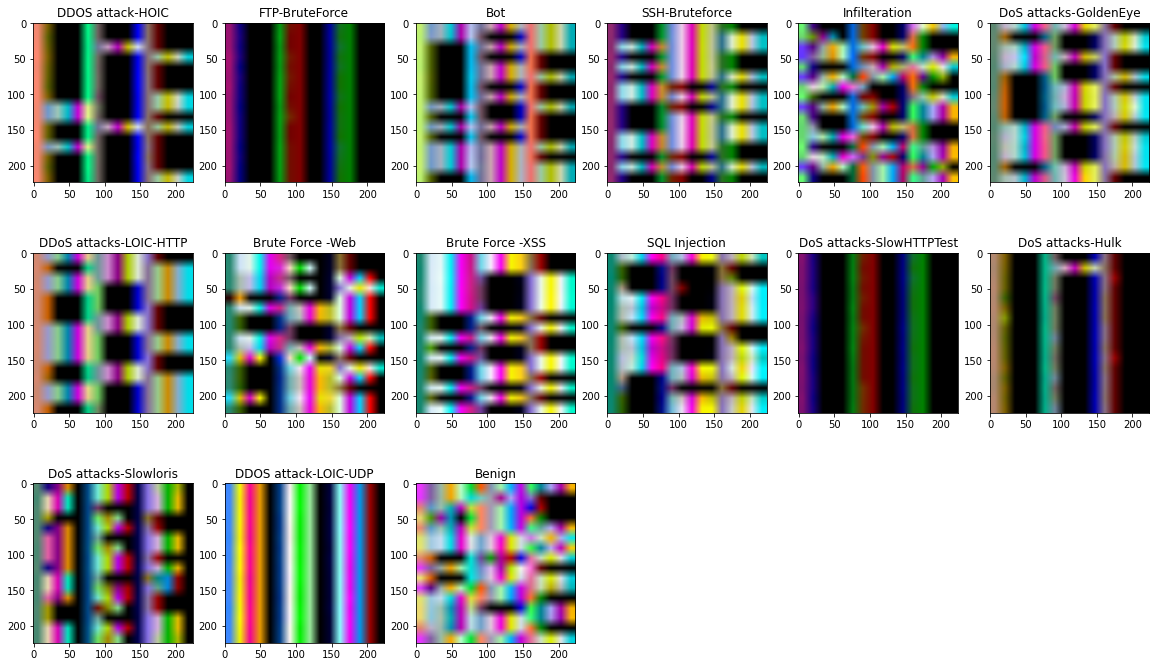

In [26]:
# df0 = reduced_df[reduced_df['Label']=='DDOS attack-HOIC'].drop(['Label'],axis=1)
# df1 = reduced_df[reduced_df['Label']=='DoS attacks-Slowloris'].drop(['Label'],axis=1)
# df2 = reduced_df[reduced_df['Label']=='DoS attacks-SlowHTTPTest'].drop(['Label'],axis=1)
# df3 = reduced_df[reduced_df['Label']=='SQL Injection'].drop(['Label'],axis=1)
# df4 = reduced_df[reduced_df['Label']=='Brute Force -XSS'].drop(['Label'],axis=1)
# df5 = reduced_df[reduced_df['Label']=='SSH-Bruteforce'].drop(['Label'],axis=1)
# df6 = reduced_df[reduced_df['Label']=='DoS attacks-GoldenEye'].drop(['Label'],axis=1)
# df7 = reduced_df[reduced_df['Label']=='Infilteration'].drop(['Label'],axis=1)
# df8 = reduced_df[reduced_df['Label']=='DDOS attack-LOIC-UDP'].drop(['Label'],axis=1)
# df9 = reduced_df[reduced_df['Label']=='Bot'].drop(['Label'],axis=1)
# df10 = reduced_df[reduced_df['Label']=='DoS attacks-Hulk'].drop(['Label'],axis=1)
# df11 = reduced_df[reduced_df['Label']=='Brute Force -Web'].drop(['Label'],axis=1)
# df12 = reduced_df[reduced_df['Label']=='DDoS attacks-LOIC-HTTP'].drop(['Label'],axis=1)
# df13 = reduced_df[reduced_df['Label']=='Benign'].drop(['Label'],axis=1)


img = [img0, img1, img2, img3, img4, img5, img6, img7, img8, img9, img10, img11, img12, img13, img14]
# title = ['DDOS attack-HOIC', 'DoS attacks-Slowloris',  'DoS attacks-SlowHTTPTest', 'SQL Injection', 'Brute Force -XSS', \
#          'SSH-Bruteforce', 'DoS attacks-GoldenEye', 'Infilteration', 'DDOS attack-LOIC-UDP', 'Bot', 'DoS attacks-Hulk', 'Brute Force -Web', 'DDoS attacks-LOIC-HTTP', 'Benign']
title = ['DDOS attack-HOIC', 'FTP-BruteForce', 'Bot', 'SSH-Bruteforce', 'Infilteration', 'DoS attacks-GoldenEye', 'DDoS attacks-LOIC-HTTP', \
         'Brute Force -Web', 'Brute Force -XSS', 'SQL Injection', 'DoS attacks-SlowHTTPTest', 'DoS attacks-Hulk', 'DoS attacks-Slowloris', 'DDOS attack-LOIC-UDP', 'Benign']

fig = plt.figure(figsize=(20, 12))
for i in range(1, 16):    
    ax1 = fig.add_subplot(3,6, i)
    ax1.imshow(img[i-1])
    plt.title(title[i-1])